In [25]:
# import pickle
import matplotlib.pyplot as plt
# from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from scipy.io import loadmat
from utils import helper
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from sklearn.manifold import MDS
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
import matplotlib.patches as mpatches
from sklearn.metrics import pairwise_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [26]:

activation_files = {
    'dual_white': 'activations/layer35_act_white_female_dual_half_hf.pkl',
    'dual_asian': 'activations/layer35_act_asian_female_dual_half_hf.pkl',
    'sw_white': 'activations/layer35_act_sw_white_female_hf.pkl',
    'sw_asian': 'activations/layer35_act_sw_asian_female_hf.pkl',
    'sa_white': 'activations/layer35_act_sa_white_female_hf.pkl',
    'sa_asian': 'activations/layer35_act_sa_asian_female_hf.pkl',
}
triplet_file = './experiment_data/triplets_new.mat'

acts_analysis = helper.ActivationAnalysis(activation_files, layer='35')


### Figures 1,2 - ORE Results and ORE index

In [44]:
ore_results = helper.Ore_bootstrap(acts_analysis.cosine_similarities, triplet_file,num_boots=10000)


Bootstrap: 0/10000
Bootstrap: 1000/10000
Bootstrap: 2000/10000
Bootstrap: 3000/10000
Bootstrap: 4000/10000
Bootstrap: 5000/10000
Bootstrap: 6000/10000
Bootstrap: 7000/10000
Bootstrap: 8000/10000
Bootstrap: 9000/10000


In [45]:
### acc and average acc of the CNNs
print("average acc of Single White(sw) CNN across faces",(ore_results.ore['sw_white'] + ore_results.ore['sw_asian'])/2 )
print("average acc of Single Asian(sa) CNN across faces", (ore_results.ore['sa_white'] + ore_results.ore['sa_asian'])/2)
print("average acc of Dual CNN across faces", (ore_results.ore['dual_white'] + ore_results.ore['dual_asian'])/2)
print("acc of the tasks:", ore_results.ore)

average acc of Single White(sw) CNN across faces 0.9371794871794872
average acc of Single Asian(sa) CNN across faces 0.9246794871794872
average acc of Dual CNN across faces 0.9477564102564102
acc of the tasks: {'dual_white': 0.9647435897435898, 'dual_asian': 0.9307692307692308, 'sw_white': 0.9737179487179487, 'sw_asian': 0.9006410256410257, 'sa_white': 0.9044871794871795, 'sa_asian': 0.9448717948717948}


In [47]:
### computing ORE index: (performance_own_race * task difficulty - performance_other_race * task difficulty ) / (performance_own_race * task difficulty )

diff_white_hf = 1 / ore_results.ore['sw_white']
diff_asian_hf = 1 / ore_results.ore['sa_asian']

ore_asian_hf = (ore_results.ore['sa_asian'] * diff_asian_hf - ore_results.ore['sa_white'] * diff_white_hf  ) / (ore_results.ore['sa_asian'] * diff_asian_hf)
ore_white_hf = (ore_results.ore['sw_white'] * diff_white_hf  - ore_results.ore['sw_asian'] * diff_asian_hf) / (ore_results.ore['sw_white'] * diff_white_hf )
ore_white_dual_half_hf = np.abs((ore_results.ore['dual_white'] * diff_white_hf - ore_results.ore['dual_asian']*diff_asian_hf)) / (ore_results.ore['dual_white']*diff_white_hf)
ore_asian_dual_half_hf = np.abs((ore_results.ore['dual_asian'] * diff_asian_hf - ore_results.ore['dual_white']*diff_white_hf)) / (ore_results.ore['dual_asian'] * diff_asian_hf)




In [57]:
all_corr = [ore_results.bootstrap_results['dual_white'],ore_results.bootstrap_results['sw_white'], ore_results.bootstrap_results['sa_white'],
            ore_results.bootstrap_results['dual_asian'], ore_results.bootstrap_results['sw_asian'], ore_results.bootstrap_results['sa_asian']]
percentile_5th = np.array([np.percentile(samples, 2.5) for samples in all_corr]) ## corrected to produce 95 percent CI but I did not chaneg the variable names
percentile_95th = np.array([np.percentile(samples, 92.5) for samples in all_corr]) ## corrected to produce 95 percent CI but I did not chaneg the variable names


### Getting the significance level

dif_wf_dual_sw =  ore_results.bootstrap_results['sw_white'] - ore_results.bootstrap_results['dual_white']
dif_sw =  ore_results.bootstrap_results['sw_white'] - ore_results.bootstrap_results['sw_asian']

dif_af_dual_sa = ore_results.bootstrap_results['sa_asian'] - ore_results.bootstrap_results['dual_asian'] 
dif_sa = ore_results.bootstrap_results['sa_asian'] - ore_results.bootstrap_results['sa_white']
diff_dual = ore_results.bootstrap_results['dual_white'] - ore_results.bootstrap_results['dual_asian']
# Compute p-values
pval_wf_dual_sw = helper.get_pvalue(dif_wf_dual_sw)
pval_sw = helper.get_pvalue(dif_sw)
pval_af_dual_sa = helper.get_pvalue(dif_af_dual_sa)
pval_sa = helper.get_pvalue(dif_sa)
pval_dual = helper.get_pvalue(diff_dual)

bonferroni_correction = 2

sig_data_sw = [
    ["Dual & SW", f"{pval_wf_dual_sw * bonferroni_correction:.6f}"],
    ["SW white and asian faces", f"{pval_sw * bonferroni_correction:.6f}"]
]
sig_data_sa = [
    ["Dual & SA", f"{pval_af_dual_sa * bonferroni_correction:.6f}"],
    ["SA white and asian faces", f"{pval_sa * bonferroni_correction:.6f}"]
]

sig_data_dual = [
    ["Dual on white and asian", f"{pval_dual * bonferroni_correction:.6f}"],
    ["---", f"{0:.6f}"]
]

headers_asian = ["Single Asian CNN", "P-Value"]
headers_white = ["Single White CNN ", "P-Value"]
headers_dual = ["Dual CNN ", "P-Value"]
print(tabulate(sig_data_sa, headers=headers_asian, tablefmt="grid"))
print(tabulate(sig_data_sw, headers=headers_white, tablefmt="grid"))
print(tabulate(sig_data_dual, headers=headers_dual, tablefmt="grid"))


+--------------------------+-----------+
| Single Asian CNN         |   P-Value |
+==========================+===========+
| Dual & SA                |    0.0248 |
+--------------------------+-----------+
| SA white and asian faces |    0      |
+--------------------------+-----------+
+--------------------------+-----------+
| Single White CNN         |   P-Value |
+==========================+===========+
| Dual & SW                |     0.056 |
+--------------------------+-----------+
| SW white and asian faces |     0     |
+--------------------------+-----------+
+-------------------------+-----------+
| Dual CNN                |   P-Value |
+=========================+===========+
| Dual on white and asian |         0 |
+-------------------------+-----------+
| ---                     |         0 |
+-------------------------+-----------+


In [58]:

class HandlerTwoColors(HandlerBase):
    def __init__(self, color1, color2):
        self.color1 = color1
        self.color2 = color2
        super().__init__()

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        w = width / 2
        h = height
        rect1 = Rectangle((xdescent, ydescent), w, h, facecolor=self.color1, transform=trans)
        rect2 = Rectangle((xdescent + w, ydescent), w, h, facecolor=self.color2, transform=trans)
        return [rect1, rect2]


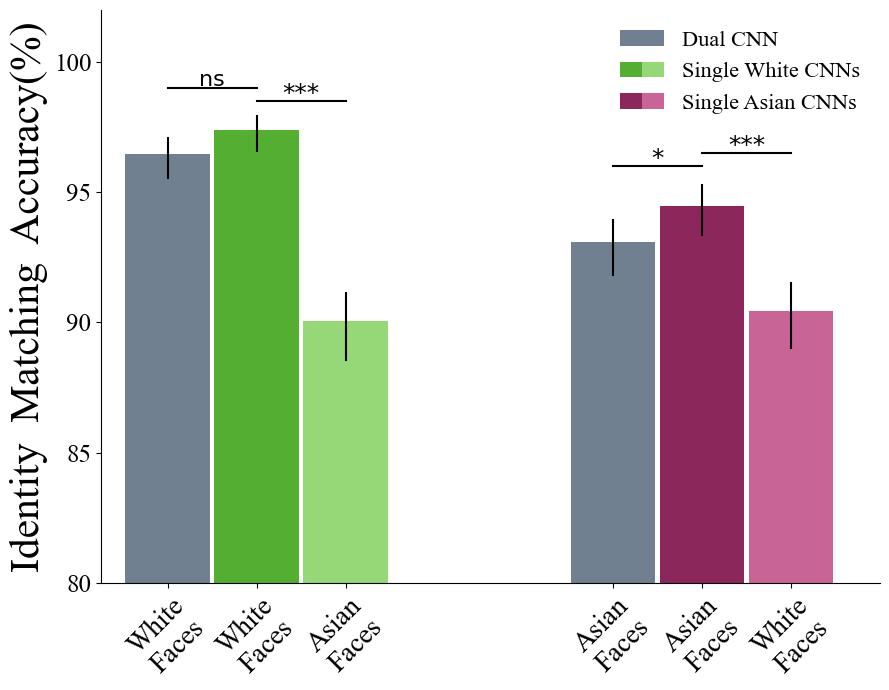

In [59]:
colors = [
    (112/255, 128/255, 144/255),    # Gray- Dual
    (140/255, 39/255, 92/255),      # Purple- Asian
    (84/255, 174/255, 50/255),      # Green- White
    (200/255, 100/255, 150/255),    # Lighter Purple
    (150/255, 215/255, 120/255),    # Lighter Green
]

labels = ['Dual CNN', 'Single White CNN', 'Single Asian CNN']
fig = plt.figure(figsize=(9, 7))
plt.rcParams['hatch.color'] = 'white' 
x = [1,3,5,7,9,11,13,15]
width = 1.9
plt.bar(x[0], ore_results.ore['dual_white']  * 100,yerr=[[ore_results.ore['dual_white']*100 - percentile_5th[0]*100], [percentile_95th[0]*100 - ore_results.ore['dual_white']*100]], color=colors[0], label=labels[0],width=width)
plt.bar(x[1], ore_results.ore['sw_white'] * 100,yerr=[[ore_results.ore['sw_white'] *100 - percentile_5th[1]*100], [percentile_95th[1]*100 - ore_results.ore['sw_white'] *100]], color=colors[2], label=labels[1],width=width)
plt.bar(x[2], ore_results.ore['sw_asian']  * 100,yerr=[[ore_results.ore['sw_asian'] *100 - percentile_5th[4]*100], [percentile_95th[4]*100 - ore_results.ore['sw_asian'] *100]], color=colors[4],width=width)


plt.bar(x[-3], ore_results.ore['dual_asian']  * 100,yerr=[[ore_results.ore['dual_asian']*100 - percentile_5th[3]*100], [percentile_95th[3]*100 - ore_results.ore['dual_asian']*100]], color=colors[0],width=width)
plt.bar(x[-2], ore_results.ore['sa_asian'] * 100,yerr=[[ore_results.ore['sa_asian'] *100 - percentile_5th[5]*100], [percentile_95th[5]*100 - ore_results.ore['sa_asian'] *100]], color=colors[1],width=width)
plt.bar(x[-1], ore_results.ore['sa_white']  * 100,yerr=[[ore_results.ore['sa_white'] *100 - percentile_5th[2]*100], [percentile_95th[2]*100 - ore_results.ore['sa_white'] *100]], color=colors[3], label=labels[2],width=width)

plt.ylim([80,102])
plt.yticks([80,85,90,95,100],fontsize=18, fontname='Times New Roman')
plt.xlim(-0.5,17)
plt.ylabel('Identity  Matching  Accuracy(%)', fontsize=30, fontname='Times New Roman')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([1,3,5,11,13,15],["White\nFaces","White\nFaces","Asian\nFaces", "Asian\nFaces","Asian\nFaces","White\nFaces"],fontsize=20, fontname='Times New Roman',rotation=45, ha='center')
plt.plot([1, 3], [.99*100, .99*100], color='black', linestyle='-', linewidth=1.5)  # Horizontal line
plt.text(2, 99.1, 'ns', fontsize=16, ha='center')  # Label above the line

plt.plot([3, 5], [.985*100, .985*100], color='black', linestyle='-', linewidth=1.5)  # Horizontal line
plt.text(4, 98.5, '***', fontsize=18, ha='center')  # Label above the line


plt.plot([11, 13], [.96*100, .96*100], color='black', linestyle='-', linewidth=1.5)  # Horizontal line
plt.text(12, 96., '*', fontsize=18, ha='center')  # Label above the line

plt.plot([13, 15], [.965*100, .965*100], color='black', linestyle='-', linewidth=1.5)  # Horizontal line
plt.text(14, 96.5, '***', fontsize=18, ha='center')  # Label above the line

dual_patch =  mpatches.Patch(facecolor=colors[0], label='Dual CNN')
sa_patch = mpatches.Patch(label='Single Asian CNNs')
sw_patch = mpatches.Patch(label='Single White CNNs')

legend_handles = [dual_patch, sw_patch, sa_patch]

plt.legend(
    handles=legend_handles,
    handler_map={
        sa_patch: HandlerTwoColors(colors[1], colors[3]),  # dark + light purple
        sw_patch: HandlerTwoColors(colors[2], colors[4]),   # dark + light green
    },
    prop={'family': 'Times New Roman', 'size':16},
    loc='upper right',
    frameon=True,
    framealpha=0.0,
    edgecolor='black'
)


plt.tight_layout()
# fig.savefig('./figures/ORE_reorganized01.png', dpi=300)

plt.show()

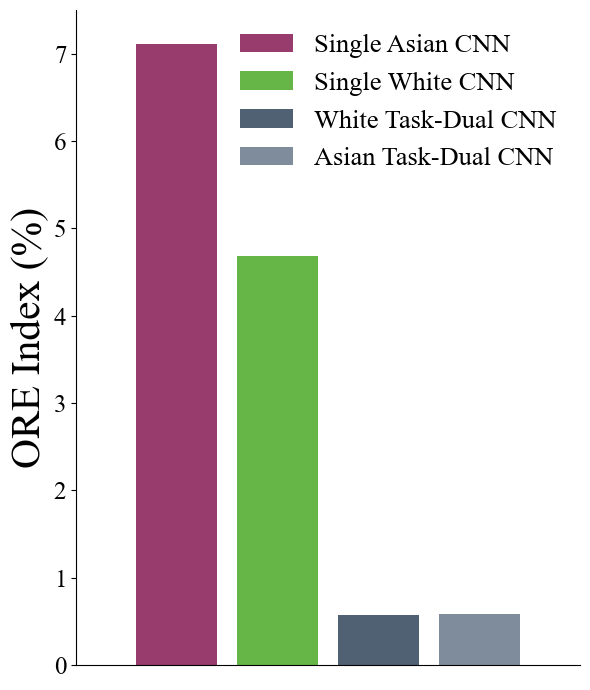

In [60]:

colors_ore = [ (112/255, 128/255, 144/255),
          (60/255, 80/255, 100/255),

          (84/255, 174/255, 50/255) ,
        (140/255, 39/255, 92/255)
][::-1]

legend_label = ['Asian Task-Dual CNN', 'White Task-Dual CNN', 'Single White CNN' , 'Single Asian CNN'][::-1]

labels = ['Asian Task\nDual CNN', 'White Task\nDual CNN',  'Single White\nCNN', 'Single Asian\nCNN'][::-1]
values = [
    ore_asian_dual_half_hf * 100, 
    ore_white_dual_half_hf * 100,
    ore_white_hf * 100, 
    ore_asian_hf * 100
][::-1]

fig = plt.figure(figsize=(6, 7))
plt.bar(range(1, len(values) + 1), values, alpha=0.9, color=colors_ore, label=legend_label)

plt.ylim([0, 7.5])
plt.xlim(0, len(values)+1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)

# plt.xticks(range(1, len(labels) + 1), labels, fontsize=22, fontname='Times New Roman', rotation=45, ha='center')
plt.xticks([])
plt.yticks(np.arange(0,8,1),fontsize=18, fontname='Times New Roman')
plt.ylabel('ORE Index (%)', fontsize=30, fontname='Times New Roman')
# plt.legend(prop={'family': 'Times New Roman', 'size': 18})
plt.legend(prop={'family': 'Times New Roman', 'size':19},
           loc='upper right',
           ncol=1,
           frameon=True,
           framealpha=0.0,
           edgecolor='black')
# plt.axhline(0,ls='--',color='gray')
plt.tight_layout()
# fig.savefig('./figures/ORE_index.png', dpi=300)
plt.show()


In [61]:
print("ORE index: Dual for Asian faces",ore_asian_dual_half_hf * 100)
print("ORE index: Dual for White faces",ore_white_dual_half_hf * 100)
print("ORE index: Single White CNN",ore_white_hf * 100)
print("ORE index: Single Asian CNN",ore_asian_hf * 100)


ORE index: Dual for Asian faces 0.5795279988828347
ORE index: Dual for White faces 0.5761888233252315
ORE index: Single White CNN 4.681139755766617
ORE index: Single Asian CNN 7.109940750493749


### Figure 3 - Lesioning Results

In [ ]:
network = 'face_dual_half_whitasia_CASIA_facecar_horizontal_flip'
suffix = 'LESION_NAME_layer12'
version = '__layer12'
# the first task is the the Asian face task, the second task is the White face task
sort_task='data_AFD_matched'  # Asian dataset
nonsort_task='dataset_white_CASIA_facecar_na' # White dataset
layer = [12]
drop_percents = np.array([0,.2])
n_drops = len(drop_percents)
prop_sort_task_sorted = np.zeros(shape=(len(layer),len(drop_percents)-1))
prop_sort_task_nonsorted = np.zeros(shape=(len(layer),len(drop_percents)-1))
prop_nonsort_task_sorted = np.zeros(shape=(len(layer),len(drop_percents)-1))
prop_nonsort_task_nonsorted = np.zeros(shape=(len(layer),len(drop_percents)-1))

drop_ind = 1
for k, i in enumerate(layer):
    
    row, col = np.unravel_index(indices=k, shape=(5,4))
    
    ## sort_task_SORTEDBY_sort_task
    rec = np.load('./lesioning/' + network + '/' + suffix + '/drop_percents_records/VERSION' + version + '/EVALUATION_TASK_' + sort_task +  '/SORTEDBY_' + sort_task + '/PARAM_GROUP_INDEX_' + str(i) + '/drop_percent_record.npz')
    sort_task_SORTEDBY_sort_task = rec['completed_accuracies']
    drop = rec['completed_drop_percents']
    indDropBase = np.where(drop==0)[0]
    base_sort_task = sort_task_SORTEDBY_sort_task[indDropBase,]
    indDrop1 = np.where(drop==drop_percents[drop_ind])[0]
    sort_task_SORTEDBY_sort_task = sort_task_SORTEDBY_sort_task[indDrop1,]
    
    prop_sort_task_SORTEDBY_sort_task = (base_sort_task-sort_task_SORTEDBY_sort_task)/base_sort_task
    sort_task_SORTEDBY_sort_task = np.append(base_sort_task, sort_task_SORTEDBY_sort_task)
    
    ## sort_task_SORTEDBY_nonsort_task
    rec = np.load('./lesioning/' + network + '/' + suffix + '/drop_percents_records/VERSION' + version + '/EVALUATION_TASK_' + sort_task +  '/SORTEDBY_' + nonsort_task + '/PARAM_GROUP_INDEX_' + str(i) + '/drop_percent_record.npz')
    sort_task_SORTEDBY_nonsort_task = rec['completed_accuracies']
    drop = rec['completed_drop_percents']
    indDrop1 = np.where(drop==drop_percents[drop_ind])[0]
    sort_task_SORTEDBY_nonsort_task = sort_task_SORTEDBY_nonsort_task[indDrop1,]
    prop_sort_task_SORTEDBY_nonsort_task = (base_sort_task-sort_task_SORTEDBY_nonsort_task)/base_sort_task
    sort_task_SORTEDBY_nonsort_task = np.append(base_sort_task, sort_task_SORTEDBY_nonsort_task)
    
    ## nonsort_task_SORTEDBY_sort_task
    rec = np.load('./lesioning/' + network + '/' + suffix + '/drop_percents_records/VERSION' + version + '/EVALUATION_TASK_' + nonsort_task +  '/SORTEDBY_' + sort_task + '/PARAM_GROUP_INDEX_' + str(i) + '/drop_percent_record.npz')
    nonsort_task_SORTEDBY_sort_task = rec['completed_accuracies']
    drop = rec['completed_drop_percents']
    indDropBase = np.where(drop==0)[0]
    base_nonsort_task = nonsort_task_SORTEDBY_sort_task[indDropBase,]
    indDrop1 = np.where(drop==drop_percents[drop_ind])[0]
    nonsort_task_SORTEDBY_sort_task = nonsort_task_SORTEDBY_sort_task[indDrop1,]
    
    prop_nonsort_task_SORTEDBY_sort_task = (base_nonsort_task-nonsort_task_SORTEDBY_sort_task)/base_nonsort_task
    nonsort_task_SORTEDBY_sort_task = np.append(base_nonsort_task, nonsort_task_SORTEDBY_sort_task)
    ## nonsort_task_SORTEDBY_nonsort_task
    rec = np.load('./lesioning/' + network + '/' + suffix + '/drop_percents_records/VERSION' + version + '/EVALUATION_TASK_' + nonsort_task +  '/SORTEDBY_' + nonsort_task + '/PARAM_GROUP_INDEX_' + str(i) + '/drop_percent_record.npz')
    nonsort_task_SORTEDBY_nonsort_task = rec['completed_accuracies']
    drop = rec['completed_drop_percents']
    indDrop1 = np.where(drop==drop_percents[drop_ind])[0]
    nonsort_task_SORTEDBY_nonsort_task = nonsort_task_SORTEDBY_nonsort_task[indDrop1,]
    
    prop_nonsort_task_SORTEDBY_nonsort_task = (base_nonsort_task-nonsort_task_SORTEDBY_nonsort_task)/base_nonsort_task
    nonsort_task_SORTEDBY_nonsort_task = np.append(base_nonsort_task, nonsort_task_SORTEDBY_nonsort_task)
    
    
    prop_sort_task_sorted[k,:] = prop_sort_task_SORTEDBY_sort_task
    prop_sort_task_nonsorted[k,:] = prop_sort_task_SORTEDBY_nonsort_task
    prop_nonsort_task_sorted[k,:] = prop_nonsort_task_SORTEDBY_nonsort_task
    prop_nonsort_task_nonsorted[k,:] = prop_nonsort_task_SORTEDBY_sort_task
    

In [63]:

layer = 12 ## last conv layer

layer_name = str(layer)
task_0_true, task_0_pred, task_1_true, task_1_pred = helper.get_pred_task_dual_net(network_name=network, lesion_name=suffix, version_name=version, task_sort_name=sort_task, task_nonsort_name = nonsort_task, layer=layer_name)

boot_prop_task1, boot_prop_task2 = helper.get_bootstrap_prop_acc(task_0_true, task_0_pred)

prop_acc_boot_0 = np.zeros(shape=(2,boot_prop_task1.shape[0]))

prop_acc_boot_0[0,:] = 1-boot_prop_task1
prop_acc_boot_0[1,:] = 1-boot_prop_task2

boot_prop_task1, boot_prop_task2 = helper.get_bootstrap_prop_acc(task_1_true, task_1_pred)
prop_acc_boot_1 = np.zeros(shape=(2,boot_prop_task1.shape[0]))
prop_acc_boot_1[0,:] = 1-boot_prop_task1
prop_acc_boot_1[1,:] = 1-boot_prop_task2

# the proportional drop in performance for each task when lesioning the top-20% face vs. object filters
prop_sort_task_SORTEDBY_sort_task = 1-prop_sort_task_SORTEDBY_sort_task
prop_sort_task_SORTEDBY_nonsort_task = 1-prop_sort_task_SORTEDBY_nonsort_task
prop_nonsort_task_SORTEDBY_nonsort_task = 1-prop_nonsort_task_SORTEDBY_nonsort_task
prop_nonsort_task_SORTEDBY_sort_task = 1-prop_nonsort_task_SORTEDBY_sort_task

# the bootstrapped 95% CIs
data_task_0 = prop_acc_boot_0
data_task_1 = prop_acc_boot_1

iteration: 0
iteration: 100
iteration: 200
iteration: 300
iteration: 400
iteration: 500
iteration: 600
iteration: 700
iteration: 800
iteration: 900
iteration: 1000
iteration: 1100
iteration: 1200
iteration: 1300
iteration: 1400
iteration: 1500
iteration: 1600
iteration: 1700
iteration: 1800
iteration: 1900
iteration: 2000
iteration: 2100
iteration: 2200
iteration: 2300
iteration: 2400
iteration: 2500
iteration: 2600
iteration: 2700
iteration: 2800
iteration: 2900
iteration: 3000
iteration: 3100
iteration: 3200
iteration: 3300
iteration: 3400
iteration: 3500
iteration: 3600
iteration: 3700
iteration: 3800
iteration: 3900
iteration: 4000
iteration: 4100
iteration: 4200
iteration: 4300
iteration: 4400
iteration: 4500
iteration: 4600
iteration: 4700
iteration: 4800
iteration: 4900
iteration: 5000
iteration: 5100
iteration: 5200
iteration: 5300
iteration: 5400
iteration: 5500
iteration: 5600
iteration: 5700
iteration: 5800
iteration: 5900
iteration: 6000
iteration: 6100
iteration: 6200
iter

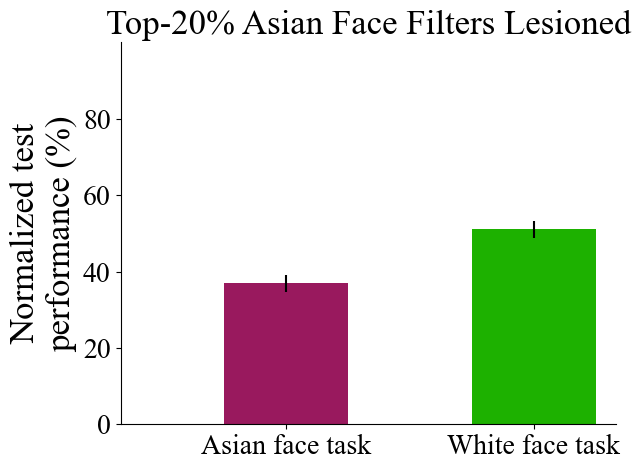

In [64]:
# create plot figure and define legend for Asian face task lesioned

fig = plt.figure(facecolor='white')
ax = plt.subplot(111)
perc_drop_index = 0 
data = [prop_sort_task_SORTEDBY_sort_task[perc_drop_index],prop_nonsort_task_SORTEDBY_sort_task[perc_drop_index]]
yerr1 = np.array([[data[0]-np.percentile(data_task_0[0,:], 2.5) ,np.percentile(data_task_0[0,:], 97.5)-data[0]]]).T
yerr2 = np.array([[data[1]-np.percentile(data_task_1[1,:], 2.5) ,np.percentile(data_task_1[1,:], 97.5)-data[1]]]).T

plt.bar([0.2], data[0], color=np.divide([153,25,94],255), width=0.15)
plt.bar([0.5], data[1], color=np.divide([29,177,0],255), width=0.15)
plt.errorbar([0.2], data[0], yerr1, color='k')
plt.errorbar([0.5], data[1], yerr2, color='k')

plt.ylabel('Normalized test\nperformance (%)', fontsize=25, fontname='Times New Roman', color='black')
plt.xticks([0.2,0.5],('Asian face task','White face task'), fontsize=20, fontname='Times New Roman')
plt.yticks(np.arange(0,1.,0.2), np.arange(0,100,20), fontsize=20, fontname='Times New Roman')    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Top-20% Asian Face Filters Lesioned', fontsize=25, fontname='Times New Roman')
plt.ylim([0, 1])
plt.xlim([0, .6])
plt.tight_layout()
# fig.savefig('./figures/lesioning_asian_face_filters.png',dpi=300)

plt.show()



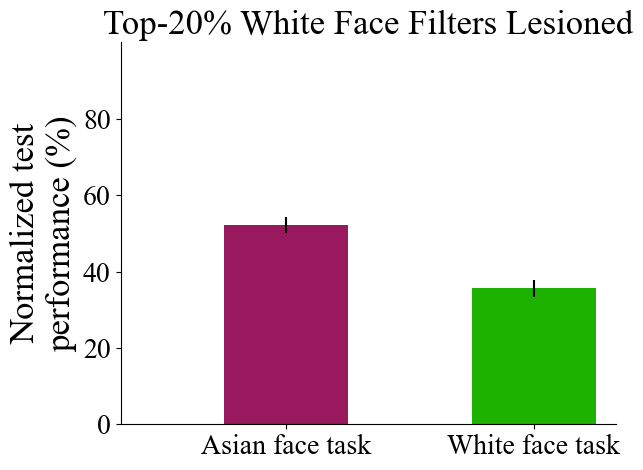

In [69]:
# create plot figure and define legend for White face task lesioned
fig = plt.figure(facecolor='white')
ax = plt.subplot(111)

perc_drop_index = 0
# White filters (non sort task) lesioned
data = [prop_sort_task_SORTEDBY_nonsort_task[perc_drop_index],prop_nonsort_task_SORTEDBY_nonsort_task[perc_drop_index]]
yerr1 = np.abs(np.array([[data[0]-np.percentile(data_task_0[1,:], 2.5) ,np.percentile(data_task_0[1,:], 97.5)-data[0]]]).T)
yerr2 = np.abs(np.array([[data[1]-np.percentile(data_task_1[0,:], 2.5) ,np.percentile(data_task_1[0,:], 97.5)-data[1]]]).T)

plt.bar([0.2], data[0], color=np.divide([153,25,94],255), width=0.15)
plt.bar([0.5], data[1], color=np.divide([29,177,0],255), width=0.15)
plt.errorbar([0.2], data[0], yerr1, color='k')
plt.errorbar([0.5], data[1], yerr2, color='k')
plt.xticks([0.2,0.5],('Asian face task','White face task'), fontsize=20, fontname='Times New Roman')
plt.yticks(np.arange(0,1.1,0.2), [], fontsize=14) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Normalized test\nperformance (%)', fontsize=25, fontname='Times New Roman', color='black')

plt.title('Top-20% White Face Filters Lesioned', fontsize=25, fontname='Times New Roman')
plt.yticks(np.arange(0,1.,0.2), np.arange(0,100,20), fontsize=20, fontname='Times New Roman')    
plt.ylim([0, 1])
plt.xlim([0, .6])
plt.tight_layout()
# fig.savefig('./figures/lesioning_white_face_filters.png',dpi=300)
plt.show()



### Figure 4,5 - RSA Results

In [72]:
def mds_from_dissim(sim_mat, n_compoments=2, random_state=1):
    sim = 1 - sim_mat.copy()
    np.fill_diagonal(sim, 0.0)
    mds = MDS(n_components=n_compoments,
            dissimilarity="precomputed",
            random_state=random_state
            )
    coords = mds.fit_transform(sim)
    return coords

mds = {}
rdm = {}
cat_rdm = {}
for key in acts_analysis.combined_cosine_similarities.keys():
    sims = acts_analysis.combined_cosine_similarities[key]
    mds[key] = mds_from_dissim(sims)
    rdm[key] = 1 - acts_analysis.combined_cosine_similarities[key]
    cat_rdm[key]= np.zeros((2,2))
    cat_rdm[key][0,0] = rdm[key][:200,:200].mean()
    cat_rdm[key][0,1] = rdm[key][:200,200:].mean()
    cat_rdm[key][1,0] = rdm[key][200:,:200].mean()
    cat_rdm[key][1,1] = rdm[key][200:,200:].mean()


cat_vals = np.stack(list(cat_rdm.values()), axis=0)
cat_vmin = cat_vals.min()
cat_vmax = cat_vals.max()

rdm_vals = np.stack(list(rdm.values()), axis=0)
rdm_vmin = rdm_vals.min()
rdm_vmax = rdm_vals.max()

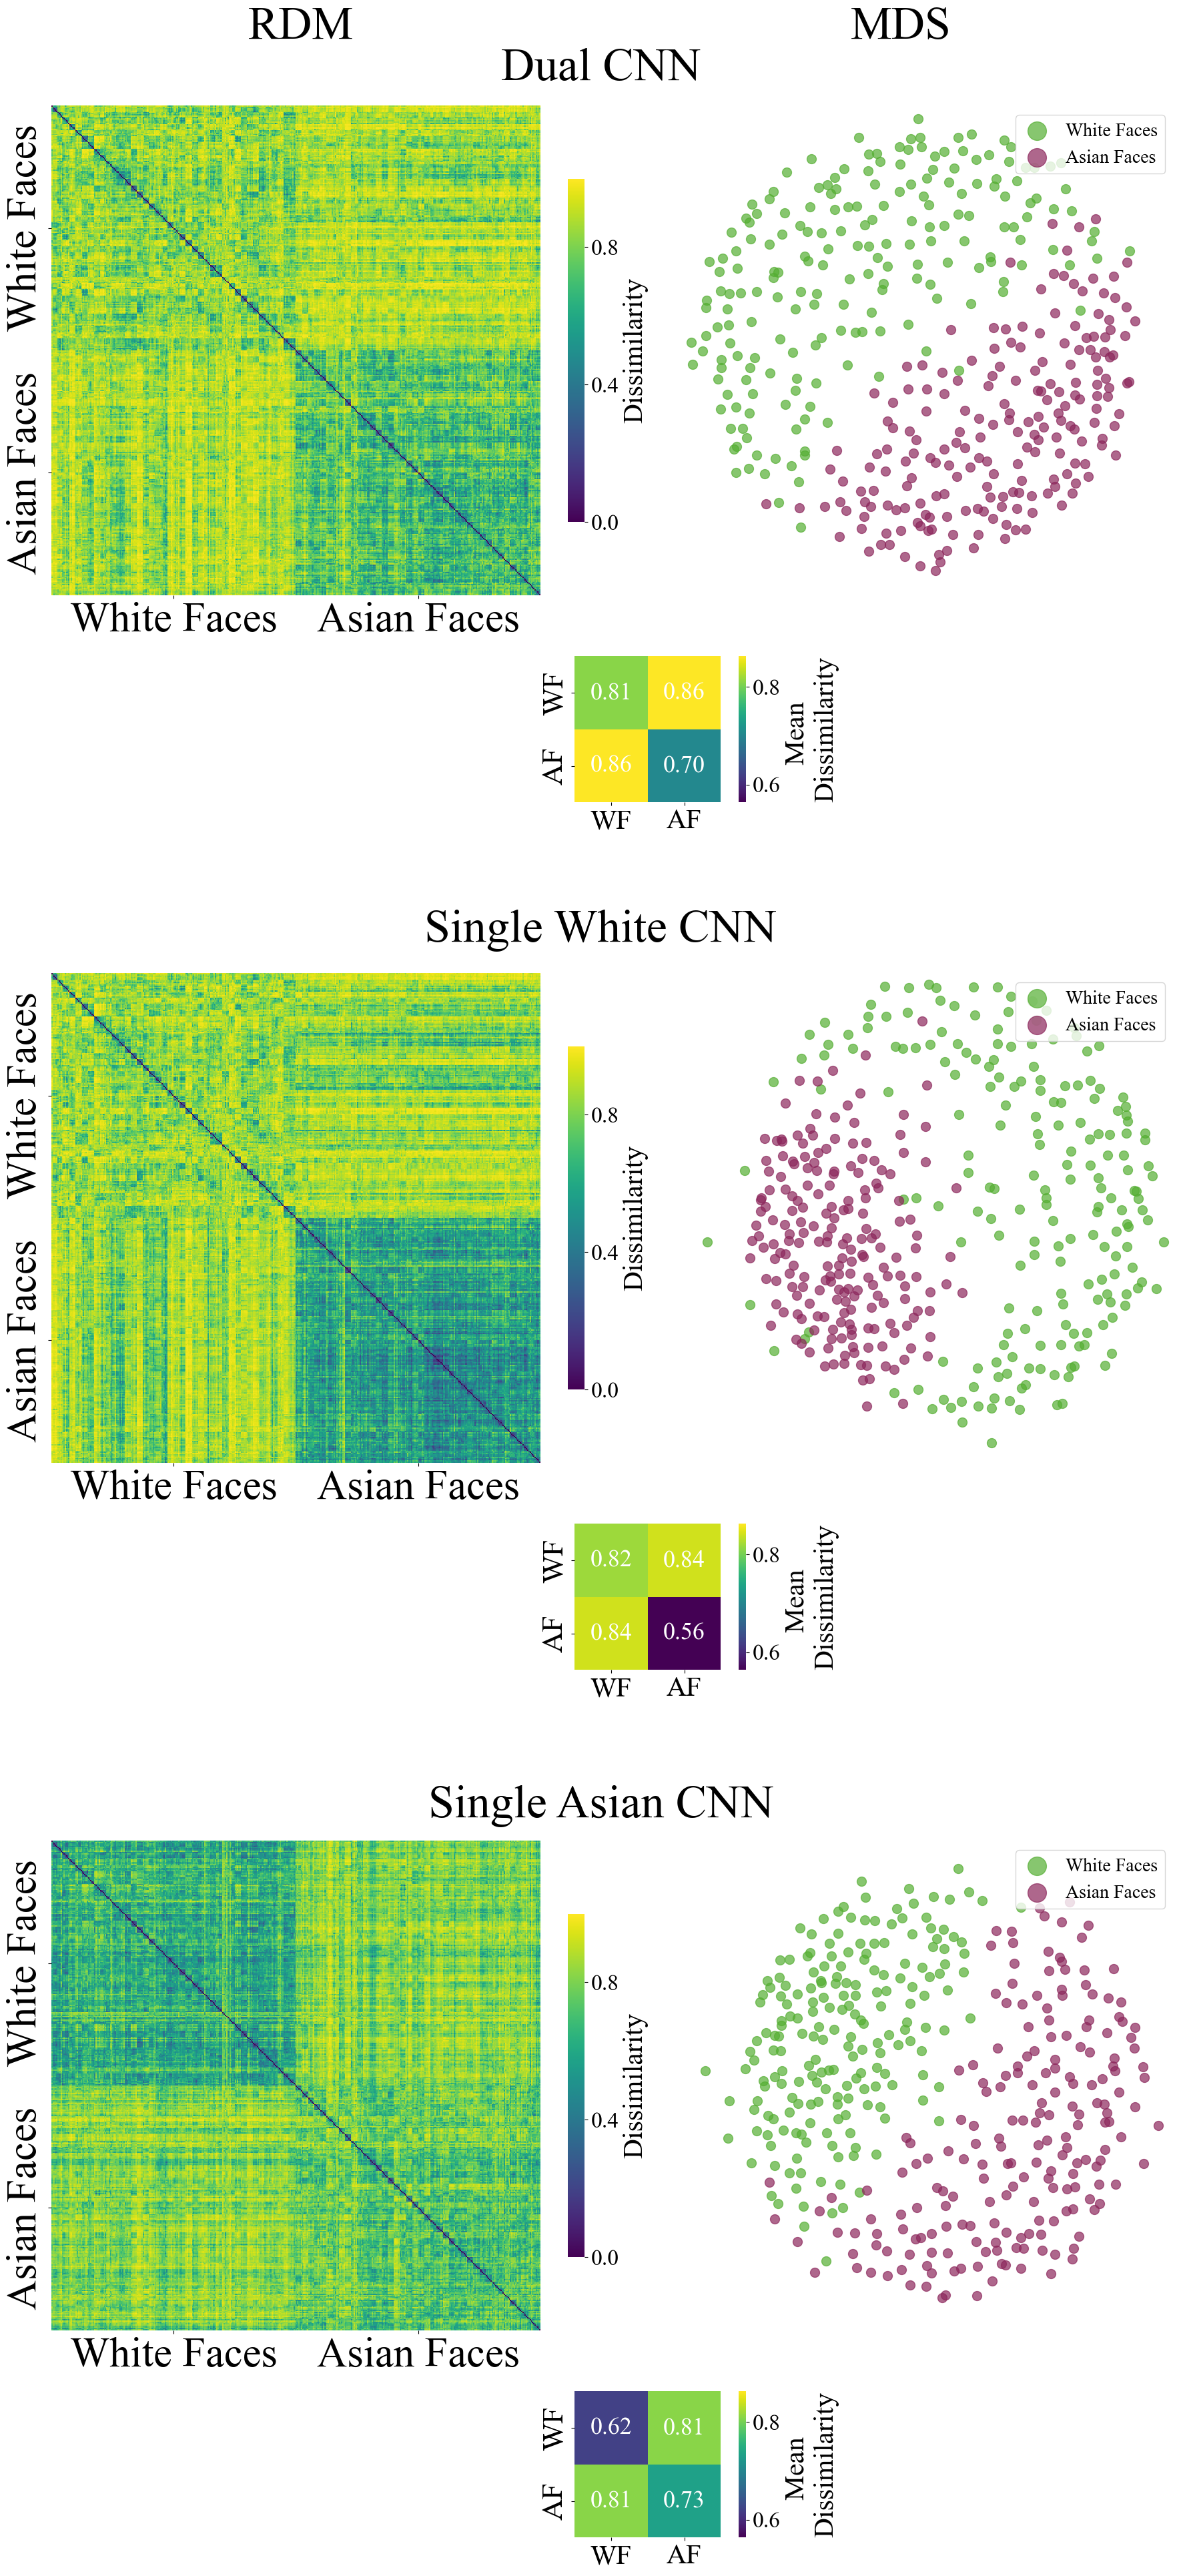

In [75]:

model_names = ["","","dual","", "sw","", "sa"]
models = ["","","Dual CNN","", "Single White CNN","", "Single Asian CNN"]
colors = [
    (112/255, 128/255, 144/255),
    (140/255, 39/255, 92/255),
    (84/255, 174/255, 50/255)
]
fig = plt.figure(figsize=(18, 41), constrained_layout=True)

outer_gs = fig.add_gridspec(
    nrows=7,
    ncols=1,
    height_ratios=[2,2,11,2, 11,2,11]  # each row same overall height
)

inner = outer_gs[0].subgridspec(1,
        2,   
        width_ratios=[1,1]   
    )
fig.text(
    0.25, 0.93, "RDM",
    ha="center", va="center",
    fontsize=50, fontname="Times New Roman"
)

fig.text(
    0.75, 0.93, "MDS",
    ha="center", va="center",
    fontsize=50, fontname="Times New Roman"
)

inner = outer_gs[1].subgridspec(1,1)
fig.text(
    0.5, 0.915, "Dual CNN",
    ha="center", va="center",
    fontsize=50, fontname="Times New Roman"
)
inner = outer_gs[3].subgridspec(1,1)
fig.text(
    0.5, 0.6, "Single White CNN",
    ha="center", va="center",
    fontsize=50, fontname="Times New Roman"
)

inner = outer_gs[5].subgridspec(1,1)
fig.text(
    0.5, 0.28, "Single Asian CNN",
    ha="center", va="center",
    fontsize=50, fontname="Times New Roman"
)

cat_axes = [] 



for row in [2,4,6]:

    # 2 rows: Top = 8 parts, Bottom = 4 parts (8:4 ratio)
    inner = outer_gs[row].subgridspec(
        2,
        2,
        height_ratios=[8, 3],    
        width_ratios=[8,8]   
    )

    # -------------------- RDM (Left) --------------------
    ax_rdm = fig.add_subplot(inner[0, 0])
    hh = sns.heatmap(
        rdm[model_names[row]],
        cmap="viridis",
        annot=False,
        cbar=True,
        vmin=rdm_vmin,
        vmax=rdm_vmax,
        ax=ax_rdm,
        cbar_kws={"shrink": 0.7}
    )
    cbar_rdm = hh.collections[0].colorbar
    cbar_rdm.ax.tick_params(labelsize=18)
    cbar_rdm.ax.set_ylabel("Dissimilarity", fontsize=30, fontname="Times New Roman")
    for tick in cbar_rdm.ax.get_yticklabels():
        tick.set_fontname("Times New Roman")
    cbar_rdm.set_ticks([0,.4,.8])
    cbar_rdm.ax.tick_params(labelsize=24)
    for label in cbar_rdm.ax.get_yticklabels():
        label.set_fontname('Times New Roman')
    # ax_rdm.set_title(f"{models[row]} ", fontsize=28, fontname='Times New Roman')
    ax_rdm.set_xticks([100, 300])
    ax_rdm.set_xticklabels(['White Faces', 'Asian Faces'], fontsize=45, rotation=0, fontname="Times New Roman")
    ax_rdm.set_yticks([100, 300])
    ax_rdm.set_yticklabels(['White Faces', 'Asian Faces'], fontsize=45, rotation=90, fontname="Times New Roman")
    ax_rdm.set_aspect('equal')

    # -------------------- MDS (Right) --------------------
    ax_mds = fig.add_subplot(inner[0, 1])
    split = 200

    ax_mds.scatter(
        mds[model_names[row]][:split, 0],
        mds[model_names[row]][:split, 1],
        alpha=0.7,
        label="White Faces",
        s=100,
        color=colors[2]
    )
    ax_mds.scatter(
        mds[model_names[row]][split:, 0],
        mds[model_names[row]][split:, 1],
        alpha=0.7,
        label="Asian Faces",
        s=100,
        color=colors[1]
    )

    ax_mds.set_xticks([])
    ax_mds.set_xticklabels([ ], fontsize=25, fontname='Times New Roman')
    ax_mds.set_yticks([])
    ax_mds.set_xlim([-.8,.8])
    ax_mds.set_ylim([-.8,.8])
    ax_mds.set_yticklabels([], fontsize=25, fontname='Times New Roman')
    ax_mds.spines['top'].set_visible(False)
    ax_mds.spines['right'].set_visible(False)
    ax_mds.spines['left'].set_visible(False)
    ax_mds.spines['bottom'].set_visible(False)

    # ax_mds.set_title(f"{models[row]} ", fontsize=26, fontname='Times New Roman')
    ax_mds.set_aspect('equal')
    # ax_mds.legend(
    # prop={'family': 'Times New Roman', 'size': 20},
    # loc='upper right'
    # )
    ax_mds.legend(
    loc='upper right',
    prop={'family':'Times New Roman', 'size':20},
    scatterpoints=1,
    markerscale=2,
    handlelength=1.5
    )

    # ----------------- Mean Dissimilarity (Centered) -----------------
    # bottom row: left empty | center heatmap | right empty
    bottom_gs = inner[1, :].subgridspec(1, 3, width_ratios=[1,1, 1])
    ax_bottom_right= fig.add_subplot(bottom_gs[0, 1])
    # hm = sns.heatmap(cat_rdm[model_names[i]], cmap="viridis", annot=False, cbar=True,vmin=cat_vmin, vmax=cat_vmax, ax=ax_bottom_right, cbar_kws={"fraction": 0.04})
    hm = sns.heatmap(
        cat_rdm[model_names[row]],
        cmap="viridis",
        annot=True,                 
        fmt=".2f",                  
        annot_kws={
            "fontsize": 26,
            "fontname": "Times New Roman",
            "color": "white"        # ensures visibility on dark colors
        },
        cbar=True,
        vmin=cat_vmin,
        vmax=cat_vmax,
        ax=ax_bottom_right,
        cbar_kws={"fraction": 0.04}
    )
    cbar_rdm = hm.collections[0].colorbar
    
    cbar_rdm.set_label('Mean \nDissimilarity', fontsize=30,fontname='Times New Roman')

    cbar_rdm.set_ticks([.6,.8])
    cbar_rdm.ax.tick_params(labelsize=24)
    for label in cbar_rdm.ax.get_yticklabels():
        label.set_fontname('Times New Roman')
    ax_bottom_right.set_xticks([0.5, 1.5])
    ax_bottom_right.set_xticklabels(['WF', 'AF'], fontsize=30, fontname='Times New Roman')

    ax_bottom_right.set_yticks([0.5, 1.5])
    ax_bottom_right.set_yticklabels(['WF', 'AF'], fontsize=32, rotation=90, fontname='Times New Roman')

    ax_bottom_right.set_aspect('equal')
    cat_axes.append(ax_bottom_right)
    

# fig.savefig('./figures/rsa_full.png',dpi=300)
plt.show()

In [74]:
cnn_names = ['sa','sw']

for cnn_id in cnn_names:
    S = acts_analysis.combined_cosine_similarities[cnn_id]
    if cnn_id == 'sw':
        trained = S[:200, :200]
        untrained = S[200:, 200:]
    elif cnn_id == 'sa':
        trained = S[200:, 200:]
        untrained = S[:200, :200]

    def mean_offdiag(mat):
        return np.mean(mat[~np.eye(mat.shape[0], dtype=bool)])

    mean_trained = mean_offdiag(trained)
    mean_untrained = mean_offdiag(untrained)
    
    Δ_within = mean_untrained - mean_trained
    print(f"Δ_within(un - trained) for {cnn_id} = {Δ_within:.4f}")

    # Bootstrap test: test H0: Δ ≤ 0 vs. H1: Δ > 0
    n_boot = 10000
    boot_deltas = []
    rng = np.random.default_rng(seed=0)

    for _ in range(n_boot):
        # resample rows/cols with replacement within each group
        idx_t = rng.choice(200, 200, replace=True)
        idx_u = rng.choice(200, 200, replace=True)
        boot_t = trained[np.ix_(idx_t, idx_t)]
        boot_u = untrained[np.ix_(idx_u, idx_u)]
        boot_deltas.append(mean_offdiag(boot_u) - mean_offdiag(boot_t))

    boot_deltas = np.array(boot_deltas)
    p_value = np.mean(boot_deltas <= 0)
    ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])

    print(f"{cnn_id} Bootstrap one-tailed p = {p_value:.4f}")
    print(f"{cnn_id} 95% CI for Δ_within: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"{cnn_id} mean trained {mean_trained:.4f}")
    print(f"{cnn_id} mean untrained {mean_untrained:.4f}")
    print(" ----------------")


Δ_within(un - trained) for sa = 0.1124
sa Bootstrap one-tailed p = 0.0000
sa 95% CI for Δ_within: [0.0921, 0.1323]
sa mean trained 0.2630
sa mean untrained 0.3754
 ----------------
Δ_within(un - trained) for sw = 0.2569
sw Bootstrap one-tailed p = 0.0000
sw 95% CI for Δ_within: [0.2364, 0.2754]
sw mean trained 0.1767
sw mean untrained 0.4337
 ----------------


In [76]:
S = acts_analysis.combined_cosine_similarities['dual']

white = S[:200, :200]
asian = S[200:, 200:]

def mean_offdiag(mat):
    return np.mean(mat[~np.eye(mat.shape[0], dtype=bool)])

mean_white = mean_offdiag(white)
mean_asian = mean_offdiag(asian)
Δ_race = mean_asian - mean_white

print(f"Mean within White: {mean_white:.4f}")
print(f"Mean within Asian: {mean_asian:.4f}")
print(f"Δ_race ( Asian - White): {Δ_race:.4f}")

# Bootstrap test: is Δ_race ≠ 0 ?
n_boot = 10000
rng = np.random.default_rng(seed=0)
boot_deltas = []

for _ in range(n_boot):
    idx_w = rng.choice(200, 200, replace=True)
    idx_a = rng.choice(200, 200, replace=True)
    boot_w = white[np.ix_(idx_w, idx_w)]
    boot_a = asian[np.ix_(idx_a, idx_a)]
    boot_deltas.append(mean_offdiag(boot_a) - mean_offdiag(boot_w))

boot_deltas = np.array(boot_deltas)
ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])
p_value = np.mean(boot_deltas <= 0)

print(f"Bootstrap one-tailed p = {p_value:.4f}")
print(f"95% CI for Δ_race: [{ci_lower:.4f}, {ci_upper:.4f}]")



Mean within White: 0.1867
Mean within Asian: 0.2935
Δ_race ( Asian - White): 0.1067
Bootstrap one-tailed p = 0.0000
95% CI for Δ_race: [0.0899, 0.1226]


In [77]:
cnn_names = ['sa', 'dual']

def mean_offdiag(mat):
    return np.mean(mat[~np.eye(mat.shape[0], dtype=bool)])

asian_means = {}

for cnn_id in cnn_names:
    S = acts_analysis.combined_cosine_similarities[cnn_id]
    asian_block = S[200:, 200:]
    asian_means[cnn_id] = mean_offdiag(asian_block)

# Difference in Asian similarity between models
Δ_asian = asian_means['sa'] - asian_means['dual']
print(f"Δ_asian(sa - dual) = {Δ_asian:.4f}")

# Bootstrap test: H0: Δ ≤ 0 vs. H1: Δ > 0
n_boot = 10000
rng = np.random.default_rng(seed=0)
boot_deltas = []

S_sa = acts_analysis.combined_cosine_similarities['sa'][200:, 200:]
S_sw = acts_analysis.combined_cosine_similarities['dual'][200:, 200:]

for _ in range(n_boot):
    idx_sa = rng.choice(200, 200, replace=True)
    idx_sw = rng.choice(200, 200, replace=True)

    boot_sa = S_sa[np.ix_(idx_sa, idx_sa)]
    boot_sw = S_sw[np.ix_(idx_sw, idx_sw)]

    boot_deltas.append(- mean_offdiag(boot_sa) + mean_offdiag(boot_sw))

boot_deltas = np.array(boot_deltas)
p_value = np.mean(boot_deltas <= 0)
ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])

print(f"Bootstrap one-tailed p = {p_value:.4f}")
print(f"95% CI for Δ_asian: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"sa mean Asian = {asian_means['sa']:.4f}")
print(f"dual mean Asian = {asian_means['dual']:.4f}")


Δ_asian(sa - dual) = -0.0305
Bootstrap one-tailed p = 0.0001
95% CI for Δ_asian: [0.0127, 0.0480]
sa mean Asian = 0.2630
dual mean Asian = 0.2935


In [ ]:
cnn_names = ['sw', 'dual']

# def mean_offdiag(mat):
#     return np.mean(mat[~np.eye(mat.shape[0], dtype=bool)])

white_means = {}

for cnn_id in cnn_names:
    S = acts_analysis.combined_cosine_similarities[cnn_id]
    asian_block = S[:200, :200]
    white_means[cnn_id] = mean_offdiag(asian_block)

# Difference in Asian similarity between models
Δ_white = white_means['sw'] - white_means['dual']
print(f"Δ_white(sw - dual) = {Δ_white:.4f}")

# Bootstrap test: H0: Δ ≤ 0 vs. H1: Δ > 0
n_boot = 10000
rng = np.random.default_rng(seed=0)
boot_deltas = []

S_sa = acts_analysis.combined_cosine_similarities['sw'][:200, :200]
S_sw = acts_analysis.combined_cosine_similarities['dual'][:200, :200]

for _ in range(n_boot):
    idx_sa = rng.choice(200, 200, replace=True)
    idx_sw = rng.choice(200, 200, replace=True)

    boot_sa = S_sa[np.ix_(idx_sa, idx_sa)]
    boot_sw = S_sw[np.ix_(idx_sw, idx_sw)]

    boot_deltas.append(- mean_offdiag(boot_sa) + mean_offdiag(boot_sw))

boot_deltas = np.array(boot_deltas)
p_value = np.mean(boot_deltas <= 0)
ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])

print(f"Bootstrap one-tailed p = {p_value:.4f}")
print(f"95% CI for Δ_asian: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"sw mean White = {white_means['sw']:.4f}")
print(f"dual mean White = {white_means['dual']:.4f}")


Δ_white(sw - dual) = -0.0100
Bootstrap one-tailed p = 0.0491
95% CI for Δ_asian: [-0.0022, 0.0222]
sw mean White = 0.1767
dual mean White = 0.1867


In [80]:
# for cnn_id in ['sw','sa','dual']:
#     S = acts_analysis.combined_cosine_similarities[cnn_id]
#     min_sim_between = np.mean(S[:200,200:])
#     print(f"{cnn_id} is : ", min_sim_between)

def find_offdiag_lower(mat):
    """Return the lower-triangular (i>j) off-diagonal entries of a square matrix."""
    n = mat.shape[0]
    return mat[np.tril_indices(n, k=-1)]
rng = np.random.default_rng(0)
n_perm = 10000
between_means = {}
between_sims = {}

for cnn_id in ['sw', 'sa', 'dual']:
    S = acts_analysis.combined_cosine_similarities[cnn_id]
    between = S[:200, 200:]  # Asian-White block
    # get lower-triangular off-diagonal values
    sims = find_offdiag_lower(between)
    between_means[cnn_id] = np.mean(sims)
    between_sims[cnn_id] = sims

print("Mean between-group similarities (lower triangle only):")
for k, v in between_means.items():
    print(f"{k}: {v:.4f}")

def perm_test(a, b, n_perm=10000):
    obs_diff = np.mean(a) - np.mean(b)
    combined = np.concatenate([a, b])
    count = 0
    for _ in range(n_perm):
        perm = rng.permutation(combined)
        perm_a = perm[:len(a)]
        perm_b = perm[len(a):]
        if abs(np.mean(perm_a) - np.mean(perm_b)) >= abs(obs_diff):
            count += 1
    return obs_diff, count / n_perm

# pairwise comparisons
bonferroni_correction = 3
pairs = [('sw', 'sa'), ('sw', 'dual'), ('sa', 'dual')]
for a, b in pairs:
    diff, p = perm_test(between_sims[a], between_sims[b])
    print(f"{a} vs {b}: Δ = {diff:.4f}, p = {p * bonferroni_correction:.4f}")

Mean between-group similarities (lower triangle only):
sw: 0.1484
sa: 0.1856
dual: 0.1286
sw vs sa: Δ = -0.0372, p = 0.0000
sw vs dual: Δ = 0.0198, p = 0.0000
sa vs dual: Δ = 0.0570, p = 0.0000


In [81]:

rng = np.random.default_rng(0)
n_perm = 10000
between_means = {}
between_sims = {}
sw_sim = find_offdiag_lower(acts_analysis.combined_cosine_similarities['sw'])
sa_sim = find_offdiag_lower(acts_analysis.combined_cosine_similarities['sa'])
dual_sim = find_offdiag_lower(acts_analysis.combined_cosine_similarities['dual'])
dissim = {}
dissim['sw'] = 1 - sw_sim
dissim['sa']= 1 - sa_sim
dissim['dual'] = 1 - dual_sim
corr_sw_sa, _ = pearsonr(dissim['sw'], dissim['sa'])
corr_sw_dual, _ = pearsonr(dissim['sw'], dissim['dual'])
corr_sa_dual, _ = pearsonr(dissim['sa'], dissim['dual'])

bonferroni_correction = 3

pairs = [('sw', 'sa'), ('sw', 'dual'), ('sa', 'dual')]
for a, b in pairs:
    diff , p = perm_test(dissim[a], dissim[b])
    print(f"{a} vs {b}: Δ = {diff:.4f}, p = {p * bonferroni_correction:.4f}")
    

sw vs sa: Δ = 0.0232, p = 0.0000
sw vs dual: Δ = -0.0431, p = 0.0000
sa vs dual: Δ = -0.0663, p = 0.0000


In [86]:
print("Similarity between Dual and SA:", corr_sa_dual)
print("Similarity between Dual and SW:", corr_sw_dual)
print("Similarity between SW and SA:", corr_sw_sa)

Similarity between Dual and SA: 0.5726070075638148
Similarity between Dual and SW: 0.8301795597526631
Similarity between SW and SA: 0.31440839999086245


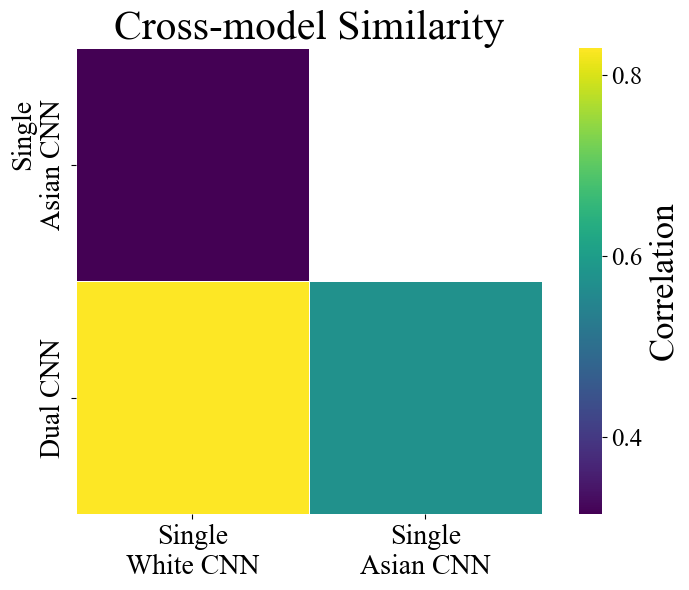

In [87]:
X = np.stack([np.asarray(dissim[k]).ravel() for k in dissim.keys()], axis=0)
model_rdm = pairwise_distances(X, metric="correlation")
n = model_rdm.shape[0]
model_names = ["Single White CNN", "Single Asian CNN", "Dual CNN"]

data = 1 - model_rdm
mask = np.triu(np.ones_like(data, dtype=bool), k=0)  
data_masked = data.copy()
data_masked[mask] = np.nan 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

hm = sns.heatmap(
    data_masked,
    cmap="viridis",
    annot=False,
    fmt=".2f",
    xticklabels=model_names,
    yticklabels=model_names,
    ax=ax,
    mask=mask,
    cbar_kws={"label": "Pearson Correlation"},
    annot_kws={
        "fontsize": 25,         # font size
        "fontname": "Times New Roman", 
        "color": "black"        # set the text color
    },
    square=True,
    linewidths=0.5,
    linecolor="white"
)

ax.set_xlim(0, n - 1)      
ax.set_ylim(n, 1)
xtick_pos = np.arange(0, n - 1) + 0.5       
ytick_pos = np.arange(1, n) + 0.5
ax.set_xticks(xtick_pos)
new_ticklabels = ["Single\nWhite CNN","Single\nAsian CNN", "Dual CNN"]
ax.set_xticklabels(new_ticklabels[: n - 1], rotation=0, fontsize=20, fontname="Times New Roman")

ax.set_yticks(ytick_pos)
ax.set_yticklabels(new_ticklabels[1:], rotation=90, fontsize=20, fontname="Times New Roman")



ax.set_title(
    "Cross-model Similarity",
    fontsize=30,
    fontname="Times New Roman"
)
# axes.tick_params(axis="both", labelsize=18)
# for tick in axes.get_xticklabels():
#     tick.set_fontname("Times New Roman")
# for tick in axes.get_yticklabels():
#     tick.set_fontname("Times New Roman")

cbar = hm.collections[0].colorbar
cbar.ax.set_ylabel("Correlation", fontsize=25, fontname="Times New Roman")

cbar.ax.tick_params(labelsize=18)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

cbar.set_ticks([0.4, 0.6,.8])

plt.tight_layout()
# plt.savefig('./figures/across_model_RDM.png',dpi=300)
plt.show()


### Figure 8 - Human CNN consistency

In [88]:
# Load the behavioral experiment data
white_ORE = loadmat('experiment_data/Mturk_white_ore.mat')
asian_ORE = loadmat('experiment_data/Mturk_asian_ore.mat')

participant_data_configs = {
    "white_human_white": {
        "triplets": white_ORE['indTriplets_white'],
        "correct_responses": white_ORE['resp_corr_white']
    },
    "asian_human_white": {
        "triplets": white_ORE['indTriplets_asian'],
        "correct_responses": white_ORE['resp_corr_asian']
    },
    "white_human_asian": {
        "triplets": asian_ORE['indTriplets_white'],
        "correct_responses": asian_ORE['resp_corr_white']
    },
    "asian_human_asian": {
        "triplets": asian_ORE['indTriplets_asian'],
        "correct_responses": asian_ORE['resp_corr_asian']
    }
}




In [89]:
beh_cnn_analysis = helper.BehavioralCNNDataCorr(acts_analysis.combined_cosine_similarities, participant_data_configs)


Bootstrap: 1000 out of 10000
Bootstrap: 2000 out of 10000
Bootstrap: 3000 out of 10000
Bootstrap: 4000 out of 10000
Bootstrap: 5000 out of 10000
Bootstrap: 6000 out of 10000
Bootstrap: 7000 out of 10000
Bootstrap: 8000 out of 10000
Bootstrap: 9000 out of 10000
Bootstrap: 1000 out of 10000
Bootstrap: 2000 out of 10000
Bootstrap: 3000 out of 10000
Bootstrap: 4000 out of 10000
Bootstrap: 5000 out of 10000
Bootstrap: 6000 out of 10000
Bootstrap: 7000 out of 10000
Bootstrap: 8000 out of 10000
Bootstrap: 9000 out of 10000


In [90]:
beh_cnn_analysis.correlations

{'af_ha_dual': 0.7670647204276989,
 'af_hw_dual': 0.7464821783633854,
 'wf_hw_dual': 0.7821464228618848,
 'wf_ha_dual': 0.7428229388014298,
 'af_ha_sw': 0.71633366301064,
 'af_hw_sw': 0.7143140296603618,
 'wf_hw_sw': 0.8019109738839959,
 'wf_ha_sw': 0.7551712682264833,
 'af_ha_sa': 0.7836755831614053,
 'af_hw_sa': 0.7548953041284465,
 'wf_hw_sa': 0.7027630393767362,
 'wf_ha_sa': 0.6733057021509358}

In [92]:
# beh_cnn_analysis.pvals

In [94]:
#### Getting the differences between the correlations of CNNs with behavior for significance level
pval_dif = {}
for ind in beh_cnn_analysis.beh_probabilities.keys():
    ## dif between single Asian and single White
    dif_sa_sw = beh_cnn_analysis.corr_boots[f'{ind}_sa'] - beh_cnn_analysis.corr_boots[f'{ind}_sw'] 
    pval_dif[f'{ind}_sa_sw'] = helper.get_pvalue(dif_sa_sw)
    ## dif between single Asian and Dual
    dif_sa_dual = beh_cnn_analysis.corr_boots[f'{ind}_sa'] - beh_cnn_analysis.corr_boots[f'{ind}_dual']
    pval_dif[f'{ind}_sa_dual'] = helper.get_pvalue(dif_sa_dual)

    ## dif between single White and Dual
    dif_sw_dual = beh_cnn_analysis.corr_boots[f'{ind}_sw'] - beh_cnn_analysis.corr_boots[f'{ind}_dual']
    pval_dif[f'{ind}_sw_dual'] = helper.get_pvalue(dif_sw_dual)


bonferroni_correction = 3
sig_data_asianfaces_asianPPT = [
    ["Dual & SW", f"{pval_dif['af_ha_sw_dual'] * bonferroni_correction:.5f}"],
    ["Dual & SA", f"{pval_dif['af_ha_sa_dual'] * bonferroni_correction:.5f}"],
    ["SA & SW", f"{pval_dif['af_ha_sa_sw'] * bonferroni_correction:.5f}"]
]
sig_data_whitefaces_whitePPT = [
    ["Dual & SW", f"{pval_dif['wf_hw_sw_dual'] * bonferroni_correction:.5f}"],
    ["Dual & SA", f"{pval_dif['wf_hw_sa_dual'] * bonferroni_correction:.5f}"],
    ["SA & SW", f"{pval_dif['wf_hw_sa_sw'] * bonferroni_correction:.5f}"]
]

sig_data_asianfaces_whitePPT = [
    ["Dual & SW", f"{pval_dif['af_hw_sw_dual'] * bonferroni_correction:.5f}"],
    ["Dual & SA", f"{pval_dif['af_hw_sa_dual'] * bonferroni_correction:.5f}"],
    ["SA & SW", f"{pval_dif['af_hw_sa_sw'] * bonferroni_correction:.5f}"]
]
sig_data_whitefaces_asianPPT = [
    ["Dual & SW", f"{pval_dif['wf_ha_sw_dual'] * bonferroni_correction:.5f}"],
    ["Dual & SA", f"{pval_dif['wf_ha_sa_dual'] * bonferroni_correction:.5f}"],
    ["SA & SW", f"{pval_dif['wf_ha_sa_sw'] * bonferroni_correction:.5f}"]
]

headers_asianPPT_asian_faces = ["Asian PPT- Asian faces", "P-Value"]
headers_asianPPT_whitefaces = ["Asian PPT- White faces", "P-Value"]
headers_whitePPT_asian_faces = ["White PPT- Asian faces", "P-Value"]
headers_whitePPT_whitefaces = ["White PPT- White faces", "P-Value"]

print(tabulate(sig_data_asianfaces_asianPPT, headers=headers_asianPPT_asian_faces, tablefmt="grid"))
print(tabulate(sig_data_asianfaces_whitePPT, headers=headers_whitePPT_asian_faces, tablefmt="grid"))

+--------------------------+-----------+
| Asian PPT- Asian faces   |   P-Value |
+==========================+===========+
| Dual & SW                |    0      |
+--------------------------+-----------+
| Dual & SA                |    0.0558 |
+--------------------------+-----------+
| SA & SW                  |    0      |
+--------------------------+-----------+
+--------------------------+-----------+
| White PPT- Asian faces   |   P-Value |
+==========================+===========+
| Dual & SW                |     0     |
+--------------------------+-----------+
| Dual & SA                |     1.197 |
+--------------------------+-----------+
| SA & SW                  |     0     |
+--------------------------+-----------+


In [95]:
print(tabulate(sig_data_whitefaces_asianPPT, headers=headers_asianPPT_whitefaces, tablefmt="grid"))
print(tabulate(sig_data_whitefaces_whitePPT, headers=headers_whitePPT_whitefaces, tablefmt="grid"))

+--------------------------+-----------+
| Asian PPT- White faces   |   P-Value |
+==========================+===========+
| Dual & SW                |     0.102 |
+--------------------------+-----------+
| Dual & SA                |     0     |
+--------------------------+-----------+
| SA & SW                  |     0     |
+--------------------------+-----------+
+--------------------------+-----------+
| White PPT- White faces   |   P-Value |
+==========================+===========+
| Dual & SW                |         0 |
+--------------------------+-----------+
| Dual & SA                |         0 |
+--------------------------+-----------+
| SA & SW                  |         0 |
+--------------------------+-----------+


In [96]:
### Getting the Pearson r correlations

correlation_coefficients_asian_ppt = [beh_cnn_analysis.correlations['af_ha_dual'],beh_cnn_analysis.correlations['af_ha_sw'],
                                      beh_cnn_analysis.correlations['af_ha_sa'], beh_cnn_analysis.correlations['wf_ha_dual'], 
                                      beh_cnn_analysis.correlations['wf_ha_sw'],beh_cnn_analysis.correlations['wf_ha_sa']
                                      ]

correlation_coefficients_white_ppt = [beh_cnn_analysis.correlations['af_hw_dual'],beh_cnn_analysis.correlations['af_hw_sw'],
                                      beh_cnn_analysis.correlations['af_hw_sa'], beh_cnn_analysis.correlations['wf_hw_dual'], 
                                      beh_cnn_analysis.correlations['wf_hw_sw'],beh_cnn_analysis.correlations['wf_hw_sa']
                                      ]


In [97]:
##### The split half reliability of triplets for white PPT is [0.64;0.68]
#### and for Asian PPTs it is [0.54;0.62]
### Spearman-Brown prophecy formula, R^2 = (2 * r) / (1 + r)
original_white_noise_ceiling = (0.78, 0.81) ## before square root 
original_asian_noise_ceiling = (0.70, 0.77) ## before square root 

white_noise_ceiling = np.sqrt(original_white_noise_ceiling)
asian_noise_ceiling = np.sqrt(original_asian_noise_ceiling)

/var/folders/6z/zs7_m22566j37f03h1k45kw00000gn/T/ipykernel_12989/4082372294.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(['',0.65, 0.7, 0.75, 0.8, 0.85, 0.9],


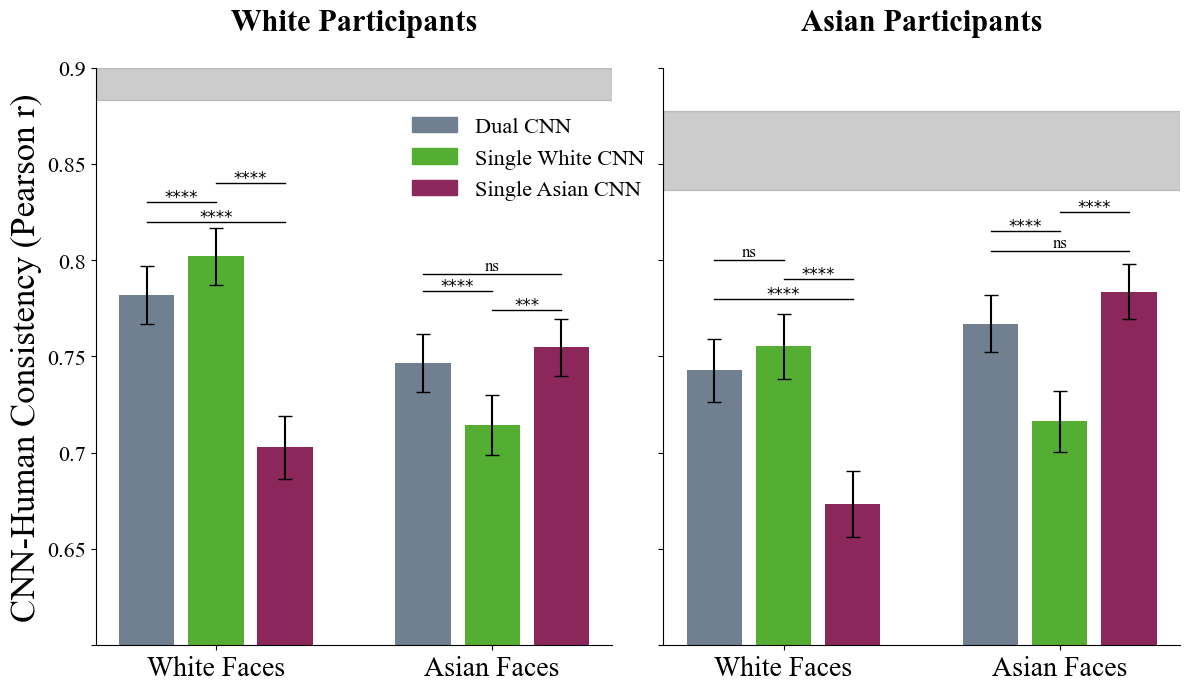

In [99]:

x_positions = [1,2,3,5,6,7,1,2,3,5,6,7]
colors = [(112/255, 128/255, 144/255),(84/255, 174/255, 50/255),(140/255, 39/255, 92/255),
          (112/255, 128/255, 144/255),(84/255, 174/255, 50/255),(140/255, 39/255, 92/255),
          (112/255, 128/255, 144/255),(84/255, 174/255, 50/255),(140/255, 39/255, 92/255),
          (112/255, 128/255, 144/255),(84/255, 174/255, 50/255),(140/255, 39/255, 92/255)
          ]
labels = ['Dual CNN','Single White CNN','Single Asian CNN']
fig, axs = plt.subplots(1, 2, figsize=(12, 7),sharey=True)
for ind, key in enumerate(beh_cnn_analysis.error_bars.keys()):
    if ind < 6:
        axs[0].bar(
        x_positions[ind],
        beh_cnn_analysis.correlations[key],
        yerr=beh_cnn_analysis.error_bars[key],
        color=colors[ind], 
        capsize=5
        )
    if ind >= 6:
        axs[1].bar(
        x_positions[ind],
        beh_cnn_analysis.correlations[key],
        yerr=beh_cnn_analysis.error_bars[key],
        color=colors[ind], 
        capsize=5
        )
        

axs[0].set_title('White Participants', fontweight='bold', fontname='Times New Roman',fontsize=22, y=1.05)
axs[0].set_ylim([0.6, 0.82])
axs[0].set_yticklabels(['',0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
                       fontsize=16, fontname='Times New Roman')
axs[0].set_xticks([2, 6])
axs[0].set_xticklabels(['White Faces','Asian Faces'], fontsize=20, fontname='Times New Roman',rotation=0, ha='center')
axs[0].set_ylabel('CNN-Human Consistency (Pearson r)', fontsize=25,fontname='Times New Roman')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].axhspan(white_noise_ceiling[0], white_noise_ceiling[1], color='gray', alpha=0.4)

axs[1].set_title('Asian Participants', fontweight='bold', fontsize=22,fontname='Times New Roman', y=1.05)
axs[1].set_ylim([0.6, 0.9])

axs[1].set_xticks([2, 6])
axs[1].set_xticklabels(['White Faces','Asian Faces'], fontsize=20,fontname='Times New Roman', rotation=0, ha='center')
# axs[1].set_ylabel('CNNs - Human Consistency (Pearson r)', fontsize=18)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].axhspan(asian_noise_ceiling[0], asian_noise_ceiling[1], color='gray', alpha=0.4)

axs[0].plot([1, 2], [.83, .83], color='black', linestyle='-', linewidth=1)  # Horizontal line
axs[0].text(1.5, .83, '****', fontsize=12, ha='center')  # Label above the line
axs[0].plot([1, 3], [.82, .82], color='black', linestyle='-', linewidth=1)  
axs[0].text(2, .82, '****', fontsize=12, ha='center')  
axs[0].plot([2, 3], [.84, .84], color='black', linestyle='-', linewidth=1)  
axs[0].text(2.5, .84, '****', fontsize=12, ha='center')  

axs[0].plot([5, 6], [.784, .784], color='black', linestyle='-', linewidth=1)  
axs[0].text(5.5, .784, '****', fontsize=12, ha='center') 
axs[0].plot([6, 7], [.774, .774], color='black', linestyle='-', linewidth=1)  
axs[0].text(6.5, .774, '***', fontsize=12, ha='center')  

axs[0].plot([5, 7], [.793, .793], color='black', linestyle='-', linewidth=1)  
axs[0].text(6, .795, 'ns', fontsize=12, ha='center', fontname='Times New Roman')  


axs[1].plot([1, 3], [.78, .78], color='black', linestyle='-', linewidth=1)  
axs[1].text(2, .78, '****', fontsize=12, ha='center') 
axs[1].plot([2, 3], [.79, .79], color='black', linestyle='-', linewidth=1)  
axs[1].text(2.5, .79, '****', fontsize=12, ha='center') 
axs[1].plot([1, 2], [.8, .8], color='black', linestyle='-', linewidth=1)  
axs[1].text(1.5, .802, 'ns', fontsize=12, ha='center', fontname='Times New Roman')


# axs[1].plot([5, 7], [.805, .805], color='black', linestyle='-', linewidth=1)  
# axs[1].text(6, .805, '*', fontsize=12, ha='center') 
axs[1].plot([5, 6], [.815, .815], color='black', linestyle='-', linewidth=1)  
axs[1].text(5.5, .815, '****', fontsize=12, ha='center') 
axs[1].plot([6, 7], [.825, .825], color='black', linestyle='-', linewidth=1)  
axs[1].text(6.5, .825, '****', fontsize=12, ha='center') 
axs[1].plot([5, 7], [.805, .805], color='black', linestyle='-', linewidth=1)  
axs[1].text(6, .807, 'ns', fontsize=12, ha='center', fontname='Times New Roman')

legend_patches = [
    mpatches.Patch(color=(112/255, 128/255, 144/255), label='Dual CNN'),
    mpatches.Patch(color=(84/255, 174/255, 50/255),   label='Single White CNN'),
    mpatches.Patch(color=(140/255, 39/255, 92/255),   label='Single Asian CNN')
]

axs[0].legend(
    handles=legend_patches,
    loc='upper right',
    bbox_to_anchor=(1.1, .95),  # (x_shift, y_shift)
    ncol=1,
    frameon=False,
    prop={'family': 'Times New Roman', 'size': 16}
)
plt.tight_layout()
# plt.savefig('./figures/human_cnn_consistency_noiseceilling_squared.png', dpi=300)

plt.show()
